In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

### Import Data

In [2]:
path = 'lalonde.csv'
patients_df = pd.DataFrame.from_csv(path, sep=",")
patients_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450


### Clean Data

In [3]:
# Cast values to numeric
patients_df.apply(pd.to_numeric, errors = 'coerce')
type(patients_df.iloc[1,1])

numpy.int64

### Split not treated and treated

In [4]:
# splits a dataframe on a two-categorical column
def split_in_two(df, column):
    first = df[df[column] == 0]
    second = df[df[column] == 1]
    return first, second

In [5]:
ntreated_df, treated_df = split_in_two(patients_df, 'treat')
ntreated_count = len(ntreated_df)
treated_count = len(treated_df)
treated_df.tail(2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW184,1,35,8,1,0,1,1,13732.07,17976.15,3786.628
NSW185,1,33,11,1,0,1,1,14660.71,25142.24,4181.942


In [6]:
ntreated_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00


### 1. A naive analysis

Now that we have the treated and untreated person, we can compare the outcome variable

In [7]:
# obtain describe serie for both groups
dscr_ntr = ntreated_df['re78'].describe()
dscr_tr = treated_df['re78'].describe()

In [8]:
# mean of untreated group
dscr_ntr['mean']

6984.1697423076967

In [9]:
# mean of treated group
dscr_tr['mean']

6349.1435302702694

We already see that the mean of untreated group is higher, but is this an effect of outliers?

In [10]:
# 75% quantile mean of untreated group
dscr_ntr['75%']

11688.82

In [11]:
# 75% quantile mean of treated group
dscr_tr['75%']

9642.9989999999998

Hence we conclude it was not an effect of outliers and that the untreated group has an average higher wage than the treated group in 1978

We will convince ourselves by showing the number in an explicit visualization

In [12]:
def get_column_serie(df, column):
    return df[[column]].values[:, 0]

In [13]:
def make_boxplot(df1, df2, column, labels,  fill_colors):
    serie1 = get_column_serie(df1, column)
    serie2 = get_column_serie(df2, column)
    data = [serie1, serie2]
    fig, ax = plt.subplots()
    
    bp = ax.boxplot(data, patch_artist = True)
    for elem in ['boxes', 'caps']:
        plt.setp(bp[elem], color='black')
    for m in bp['medians']:
        m.set(color='red', linewidth=2)
    for idx, b in enumerate(bp['boxes']):
        b.set(facecolor = fill_colors[idx])
    
    ax.set_xticklabels(labels)

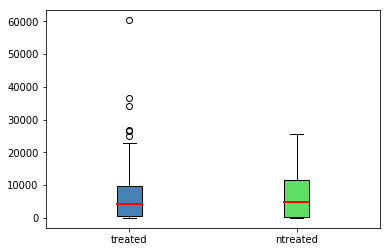

In [14]:
make_boxplot(treated_df, ntreated_df, 're78', ['treated', 'ntreated'], ['steelblue', '#5EDF63'])

Hence the plots confirms what we already knew, that the mean and mean without outliers is lower for treated patients. The naive analysis concludes the treatment does not work

### 2. A closer look at the data

#### Description
For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Solution
In this part, we will successively compare the columns of the treated dataframe and the ntreated dataframe then try to explain what vice of procedure caused the discrepancies in the case of high difference in distribution

In [15]:
def shared_plot_by(col,plot_kind, treated_df, ntreated_df):
    fig, axs = plt.subplots(1, 2, figsize=(14,5), sharex=True)
    treated_df.plot(y=col, kind=plot_kind, ax=axs[0], title = "Treated")
    ntreated_df.plot(y=col, kind=plot_kind, ax=axs[1], title = "Not Treated")
    plt.show()

Lets first compare both groups **by age**

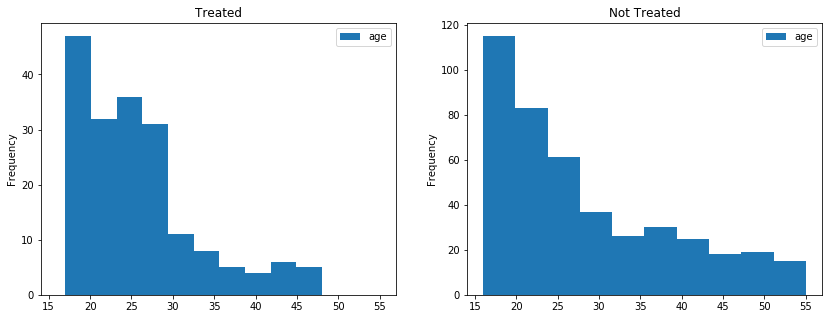

In [16]:
# First we can compare them by age
shared_plot_by('age', 'hist', treated_df, ntreated_df)

We already see that there is a big difference in proportion between 25 and 30 years. There are proportionately way more treated people in this age range than there are untreated people relative to the total number of people in each group

In [17]:
# And we can compare the values with descibe
treated_df['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [18]:
ntreated_df['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

We can see (with plots and numbers) that among the data, most of them are young people (16-25) and there are much more people not treated than treated. We can suspect that the treatment **assignement was not random** because had it be random, the number of patients in each group would have been closer to each other.

Now we can compare both groups through their respective <b>years of education</b> distribution

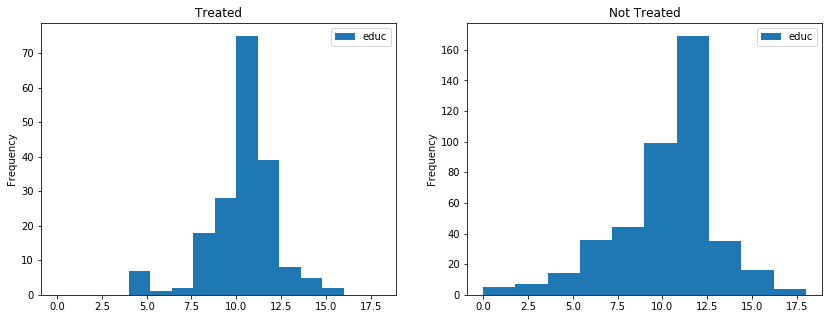

In [19]:
# Then by education
shared_plot_by('educ', 'hist', treated_df, ntreated_df)

The results here are less surprising. Since we already saw a difference in age distribution, the years of education will be influenced. Here both groups seem quite comparable

In [20]:
# and compare their values too
treated_df['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [21]:
ntreated_df['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

The results confirm our hypotheses since the mean is almost the same in both groups and the 75% quantile is exactly the same. This means that the difference in standard deviation is only due to outliers. Hence both groups have very **similar distributions in years of education**

We can now compare the **amount of people without a degree** and the **number of people married** in each group

In [22]:
def col_number(df, col_names):
    result_0 = []
    result_1 = []
    
    for col_name in col_names:   
        # for each col we calculate the length and then store the ratio
        nb_0 = len(df[df[col_name] == 0])
        nb_1 = len(df[df[col_name] == 1])
        result_0.append(nb_0 / (nb_0 + nb_1))
        result_1.append(nb_1 / (nb_0 + nb_1))
        
    return np.array(result_0), np.array(result_1)

def bar_subplot(axe_plot, nb_index, result_0, result_1, ylegend):
    #plot0 = axe_plot.bar(nb_index, result_0, color="#0000ff")
    plot1 = axe_plot.bar(nb_index, result_1, color='steelblue')
    
    plt.sca(axe_plot)
    plt.xticks(nb_index, col_names)
    plt.ylabel(ylegend)
    plt.yticks( [0, 0.5, 1] )
    #plt.legend((plot0[0], plot1[0]), ('0', '1'))

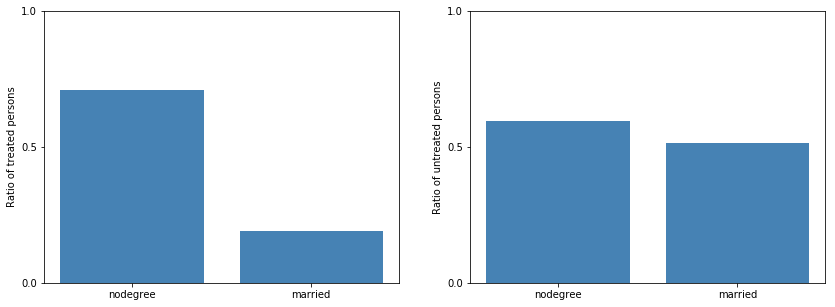

In [23]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(2)
col_names = ['nodegree', 'married']

result_0, result_1 = col_number(treated_df, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(ntreated_df, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons')

plt.show()

We see that the <b>proportion of people without a degree is quite similar</b> . However the <b>proportion of people married is very different</b>. there seem to be a ratio between 2 and 3 of the proportion of married people.
This may show a bias in the treatment assignement but <b>might be a side effect of the age difference</b> we saw before between the groups. This may have a big influence since we may expect married people to have different carreer objectives than unmarried people.

For <b>blacks and hispanic</b> we will only compare the ratios between the two groups

In [24]:
def compute_ratio(df, col, total):
    val = df[col]
    return (val == 1).sum()/total

In [25]:
print("the ratio of treated blacks :",compute_ratio(treated_df, 'black', treated_count))

the ratio of treated blacks : 0.843243243243


In [26]:
print("the ratio of untreated blacks :",compute_ratio(ntreated_df, 'black', ntreated_count))

the ratio of untreated blacks : 0.202797202797


In [27]:
print("the ratio of treated hispanic :",compute_ratio(treated_df, 'hispan', treated_count))

the ratio of treated hispanic : 0.0594594594595


In [28]:
print("the ratio of untreated hispanic",compute_ratio(ntreated_df, 'hispan', ntreated_count))

the ratio of untreated hispanic 0.142191142191


We can see that the percentage of blacks in the treated group is 4 time larger than the one in the non-treated one. <br>
For the Hispanics, we can see that we have almost twice as much Hispanic in the untreated group this time.<br>
This is a <b>non-random treatment assignement</b>

### 3. A propsensity score model

#### Description
Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores

#### Solution
We apply the logistic regression

In [29]:
logistic = linear_model.LogisticRegression()
feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = patients_df[feature_cols]
y = patients_df.treat
logistic.fit(X, y);

Then add the results in a new dataframe

In [30]:
score = logistic.predict_proba(X)
patients_score_df = patients_df.copy()
patients_score_df["score"] = score[:,1]
patients_score_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450,0.722355


The score column give the probability of being treated given the pre-treatment features (all but re78)

### 4. Balancing the dataset via matching

#### Description
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

#### Solution

First we need to separate the patient treated from the untreated and then see if it match with the propsensity score.

In [31]:
patients_treated = patients_score_df.loc[patients_score_df['treat'] == 1]
patients_not_treated = patients_score_df.loc[patients_score_df['treat'] == 0]
patients_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


In [32]:
patients_not_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.050504
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.033330
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.022574
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.024906
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.416054


In [33]:
len(patients_treated.index)

185

In [34]:
len(patients_not_treated.index)

429

We can see that there are less the patient treated than not treated. That's why we need to find only 1 match with the untreated patients. <br>
To do this, we need to see the distance between each data point from the treated group with exactly one data point from the control group (the not treated ones).

In [35]:
#To calculate the distance (here we have 1 axis)
def compute_dist(x1, x2):
    return np.sqrt(np.power(x1 - x2, 2))

In [36]:
def matching_only_one(treated, ntreated, match_score):
    matching = []
    idx_npatient_used = []
    
    for patient_idx in treated.index:
        patient = treated.loc[patient_idx]
        patient_score = patient[match_score]
        
        min_dist = 10000000 # an arbitrary big number (the distance will be always below)
        match = []
        
        for npatient_idx in ntreated.index:
            npatient = ntreated.loc[npatient_idx]
            npatient_score = npatient[match_score]
            
            dist = compute_dist(patient_score, npatient_score)
            
            if(dist < min_dist):
                # we need to look if the untreated patient index was already used
                if(npatient_idx not in idx_npatient_used):
                    match = [patient_idx, npatient_idx]
                    min_dist = dist
                    
        matching.append(match)
        idx_npatient_used.append(match[1])
        
    return matching   

In [37]:
matching = matching_only_one(patients_treated, patients_not_treated, "score")

Verification that we have only one match and that they are all different

In [38]:
def verify_one_match(list_):
    for i in range(len(list_)):
        psid1 = list_[i][1]
        for j in range(len(list_)):
            psid2 = list_[j][1]
            if(i != j and psid1 == psid2):
                return False
    
    return True
                

In [39]:
verify_one_match(matching)

True

Now that we have the match we can compare the values of the treated and not treated persons

In [40]:
patients_treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [41]:
patients_not_treated_matched = patients_not_treated.loc[np.array(matching)[:,1]]
patients_not_treated_matched['re78'].describe()

count      185.000000
mean      5312.474907
std       5842.884861
min          0.000000
25%          0.000000
50%       3392.860000
75%       7933.914000
max      20243.380000
Name: re78, dtype: float64

We can see that they look alike and our conclusion will be better than what we have done before. We can plot them to see the differences.

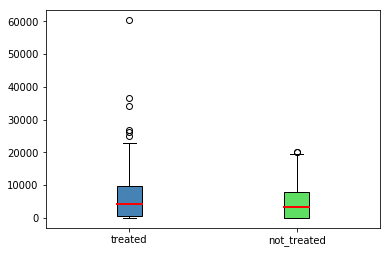

In [42]:
make_boxplot(patients_treated, patients_not_treated_matched, 're78', ['treated', 'not_treated'], ['steelblue', '#5EDF63'])

We can see that the plots are very similar and give us better informations about the treated and untreated people.
Here with this analysis, we can conclude that the treatment doesn't really work because the real earnings are not higher for the treated persons than the untreated ones. So it seems logical to say that applying for this job training program has no influence. Furthermore, the differences could be caused by economic fluctuations or that maybe a higher salary involves having more experiences and better skills than the training job can bring.

We can now compare the age, education and the other parameters that we have to see how the repartition of the data looks.

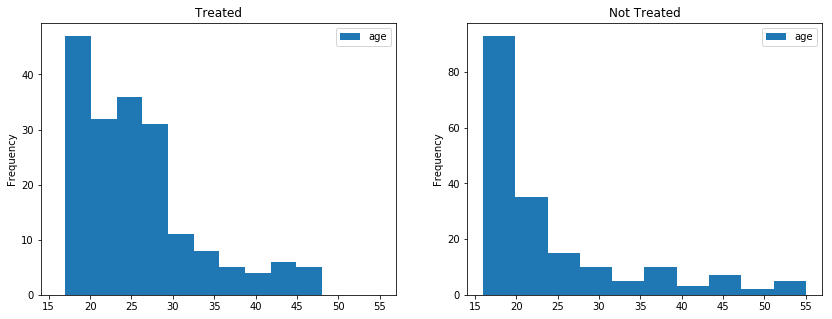

In [43]:
shared_plot_by('age', 'hist', patients_treated, patients_not_treated_matched)

In [44]:
patients_treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [45]:
patients_not_treated_matched['age'].describe()

count    185.000000
mean      23.713514
std        9.644726
min       16.000000
25%       17.000000
50%       19.000000
75%       26.000000
max       55.000000
Name: age, dtype: float64

Now we can see that we have the same number of treated and untreated persons and the distributions of both graph are similar. So we can hope that these changes will leads to very good results. However, we can see that there is still a difference betweeen young people (15-20). There are a lot more of untreated young people than treated. So we will have again bias results but less than with the naive approch. Let's see if it's also the case for the years of educations.

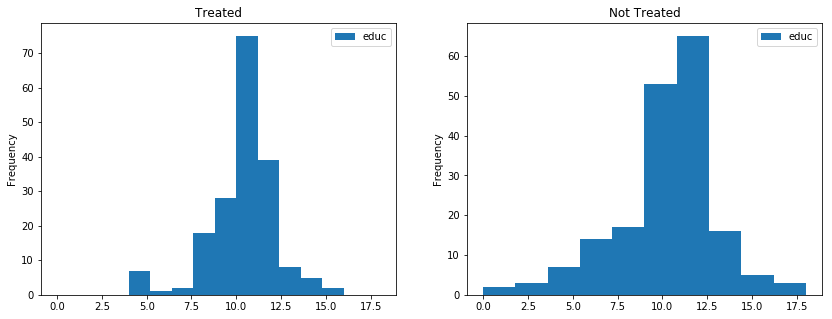

In [46]:
shared_plot_by('educ', 'hist', patients_treated, patients_not_treated_matched)

In [47]:
patients_treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [48]:
patients_not_treated_matched['educ'].describe()

count    185.000000
mean      10.162162
std        2.861984
min        0.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

Again, the distribution of education for treated and untreated person are similar. These distributions look like gaussians but it's not random so we will have bias on our final results. For example, if we look at the graph, most of the people who studied for a long time (around 10 years) took this job training program. Maybe the reason is that after about 10 years of study, another training can bring or supplement useful skills for a job. <br>
However we don't have the same proportion (again) of people for each year of education so this supports our hypothesis that this is a <b>non-random treatment assignment</b>

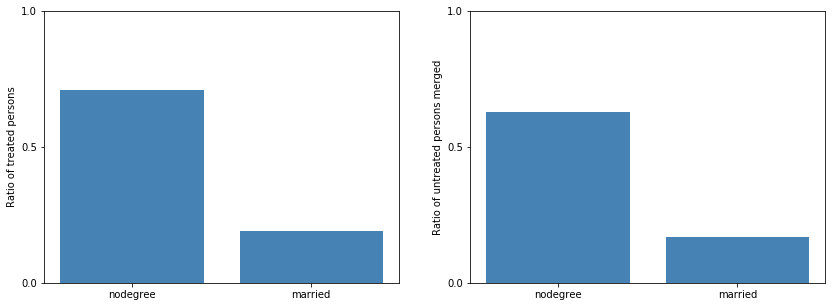

In [49]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(2)
col_names = ['nodegree', 'married']

result_0, result_1 = col_number(patients_treated, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(patients_not_treated_matched, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons merged')

plt.show()

We can see that the proportion of person without a degree is very similar in both groups. However it is still a little bit higher in the treatment group, which one can conclude that if someone has a diploma, he will normally take the training (for more skills). <br>
For the married people we can see that the proportions are the same which wasn't the case with the naive approach. This shows that now, we have similar groups with "similar" married persons and therefore will lead to better results. However the final result did not depend only on married people and this is why we can't say that this research is a random treatment assignment.

In this part, we will look at <b>blacks and hispanic</b> and compare the ratios between the two groups

In [50]:
patient_not_treated_count = len(patients_not_treated_matched)
patient_treated_count = len(patients_treated)
print("Percentage of treated black:",compute_ratio(patients_treated, 'black', patient_treated_count))

Percentage of treated black: 0.843243243243


In [51]:
print("percentatge of untreated black:",compute_ratio(patients_not_treated_matched, 'black', patient_not_treated_count))

percentatge of untreated black: 0.47027027027


In [52]:
print("percentage of treated hispanic:",compute_ratio(patients_treated, 'hispan', patient_treated_count))

percentage of treated hispanic: 0.0594594594595


In [53]:
print("percentage of untreated hispanic:",compute_ratio(patients_not_treated_matched, 'hispan', patient_not_treated_count))

percentage of untreated hispanic: 0.118918918919


We can see now that the proportion of blacks in the treated group is almost twice as important as the one of the non-treated group. In addition, for Hispanics, we have the same problem, almost twice as much hispanic in the untreated group this time.<br>
With these results, we can conclude that since the proportion of blacks and hipanics are not the same in both groups, the final results will not be good. Indeed to have the best results possible, there should be similar proportions. <br>
Finally, we can conclude that with all these differences seen previously, this is a <b>non-random treatment assignement</b>

### 5. Balancing the groups further

kevin part

As we saw in the previous part, our matching were only on the score of the prediction and nothing else. We have 185 persons but maybe we can do a better match. First we will filter our people and keep only the people how have a better matching to see if it can improve te result. Then we will test with an other matching function to find better results 

In [54]:
patients_not_treated_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
PSID97,0,24,12,1,0,1,0,8573.7520,4293.194,0.000,0.439327
PSID395,0,53,12,0,0,0,0,0.0000,0.000,0.000,0.143760
PSID352,0,24,12,1,0,0,0,566.2281,0.000,2284.565,0.721966
PSID179,0,18,11,1,0,0,1,2068.9860,1623.823,20243.380,0.663845
PSID355,0,19,9,1,0,0,1,384.0163,0.000,0.000,0.698314


In [55]:
patients_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


What can happen if we took only those who have at maximum an interval of 10 years?

In [56]:
def reindex(treated, ntreated, match_score):
    matching = []
    
    indexes1 = treated.index
    indexes2 = ntreated.index
    
    for idx_1, idx_2 in zip(indexes1, indexes2):
        patient = treated.loc[idx_1]
        patient_age = patient["age"]
        patient_hisp = patient["hispan"]
        patient_black = patient["black"]
        npatient = ntreated.loc[idx_2]
        npatient_age = npatient["age"]
        npatient_hisp = npatient["hispan"]
        npatient_black = npatient["black"]
        
        dist = compute_dist(patient_age, npatient_age)
            
        if(dist < 7 and patient_hisp == npatient_hisp and patient_black == npatient_black):                    
            matching.append([idx_1, idx_2])
        
    return matching

In [57]:
matching  = reindex(patients_treated, patients_not_treated_matched, "score")

In [58]:
len(matching)

48

In [59]:
new_patients_not_treated_matched = patients_not_treated.loc[np.array(matching)[:,1]]
new_patients_treated_matched = patients_treated.loc[np.array(matching)[:,0]]
new_patients_treated_matched['re78'].describe()

count       48.000000
mean      5265.893429
std       6349.538209
min          0.000000
25%          0.000000
50%       2335.040000
75%       9360.090750
max      24909.450000
Name: re78, dtype: float64

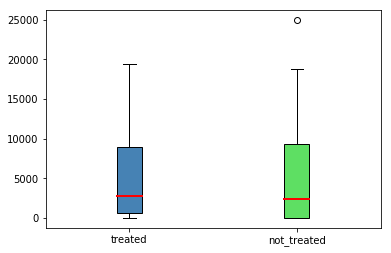

In [60]:
make_boxplot(new_patients_not_treated_matched, new_patients_treated_matched, 're78', ['treated', 'not_treated'], ['steelblue', '#5EDF63'])

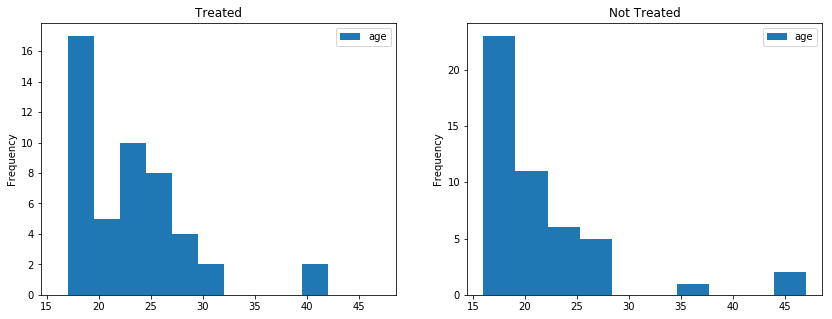

In [61]:
shared_plot_by('age', 'hist', new_patients_treated_matched, new_patients_not_treated_matched)

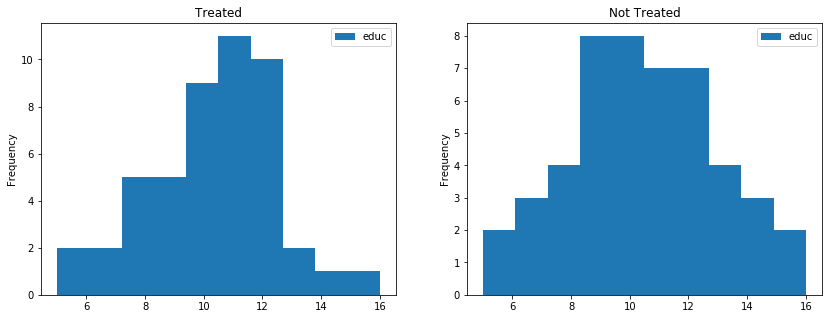

In [62]:
shared_plot_by('educ', 'hist', new_patients_treated_matched, new_patients_not_treated_matched)

In [63]:
patient_not_treated_count = len(new_patients_not_treated_matched)
patient_treated_count = len(new_patients_treated_matched)
print("Percentage of treated black:",compute_ratio(new_patients_treated_matched, 'black', patient_treated_count))

Percentage of treated black: 0.8125


In [64]:
print("percentatge of untreated black:",compute_ratio(new_patients_not_treated_matched, 'black', patient_not_treated_count))

percentatge of untreated black: 0.8125


In [65]:
print("percentage of treated hispanic:",compute_ratio(new_patients_treated_matched, 'hispan', patient_treated_count))

percentage of treated hispanic: 0.0


In [66]:
print("percentage of untreated hispanic:",compute_ratio(new_patients_not_treated_matched, 'hispan', patient_not_treated_count))

percentage of untreated hispanic: 0.0


We can see here that the results (numbers and distribution are more similar) so it will lead to better results.
However we don't have any hispanic in our match. <br>
So maybe we can split better the data at the beginning so the results will be better. Let's check

In [67]:
logistic = linear_model.LogisticRegression()
feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = patients_df[feature_cols]

X_black = X.loc[(X['black'] == 1)]
X_hispan = X.loc[(X['hispan'] == 1)]
X_noBlack_noHispan = X.loc[((X['hispan'] == 0) & (X['black'] == 0))]

y_black = patients_df.loc[((patients_df['black'] == 1))].treat
y_hispan = patients_df.loc[((patients_df['hispan'] == 1))].treat
y_noBlack_noHispan = patients_df.loc[((patients_df['hispan'] == 0) & (patients_df['black'] == 0))].treat

logistic.fit(X_black, y_black)
score_b = logistic.predict_proba(X_black)
black = patients_df.copy()
patients_black = black.loc[black['black'] == 1]
patients_black_score_df = patients_black.copy()
patients_black_score_df["score"] = score_b[:,1]

logistic.fit(X_hispan, y_hispan)
score_h = logistic.predict_proba(X_hispan)
hispan = patients_df.copy()
patients_hispan = hispan.loc[hispan['hispan'] == 1]
patients_hispan_score_df = patients_hispan.copy()
patients_hispan_score_df["score"] = score_h[:,1]

logistic.fit(X_noBlack_noHispan, y_noBlack_noHispan)
score_nb_nh = logistic.predict_proba(X_noBlack_noHispan)
noBlack_noHispan = patients_df.copy()
patients_noBlack_noHispan = noBlack_noHispan.loc[((noBlack_noHispan['hispan'] == 0) & (noBlack_noHispan['black'] == 0))]
patients_noBlack_noHispan_score_df = patients_noBlack_noHispan.copy()
patients_noBlack_noHispan_score_df["score"] = score_nb_nh[:,1]

patients_black_treated = patients_black_score_df.loc[patients_black_score_df['treat'] == 1]
patients_black_not_treated = patients_black_score_df.loc[patients_black_score_df['treat'] == 0]

patients_hispan_treated = patients_hispan_score_df.loc[patients_hispan_score_df['treat'] == 1]
patients_hispan_not_treated = patients_hispan_score_df.loc[patients_hispan_score_df['treat'] == 0]

patients_noBlack_noHispan_treated = patients_noBlack_noHispan_score_df.loc[patients_noBlack_noHispan_score_df['treat'] == 1]
patients_noBlack_noHispan_not_treated = patients_noBlack_noHispan_score_df.loc[patients_noBlack_noHispan_score_df['treat'] == 0]


patients_black_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.656284
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.645230
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.745107
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.687412
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.686153


In [68]:
def print_len(df):
    print(len(df))

In [69]:
print_len(patients_black_treated)
print_len(patients_black_not_treated)
print_len(patients_hispan_treated)
print_len(patients_hispan_not_treated)
print_len(patients_noBlack_noHispan_treated)
print_len(patients_noBlack_noHispan_not_treated)

156
87
11
61
18
281


In [70]:
matching_black = matching_only_one(patients_black_not_treated, patients_black_treated, "score")
matching_hispan = matching_only_one(patients_hispan_treated, patients_hispan_not_treated, "score")
matching_noBlack_noHispan = matching_only_one(patients_noBlack_noHispan_treated, patients_noBlack_noHispan_not_treated, "score")

In [71]:
verify_one_match(matching_black)

True

In [72]:
verify_one_match(matching_hispan)

True

In [73]:
verify_one_match(matching_noBlack_noHispan)

True

First, we will look at the black person

In [74]:
patients_black_not_treated['re78'].describe()

count       87.000000
mean      4853.431497
std       6201.725283
min          0.000000
25%          0.000000
50%       1613.677000
75%       8044.004500
max      20243.380000
Name: re78, dtype: float64

In [75]:
patients_black_treated_matched = patients_black_treated.loc[np.array(matching_black)[:,1]]
patients_black_treated_matched['re78'].describe()

count       87.000000
mean      6326.817184
std       7617.342306
min          0.000000
25%          0.000000
50%       4032.708000
75%       9744.273500
max      36646.950000
Name: re78, dtype: float64

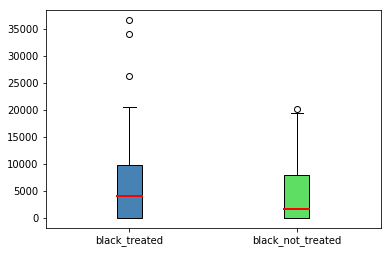

In [76]:
make_boxplot(patients_black_treated_matched, patients_black_not_treated, 're78', ['black_treated', 'black_not_treated'], ['steelblue', '#5EDF63'])

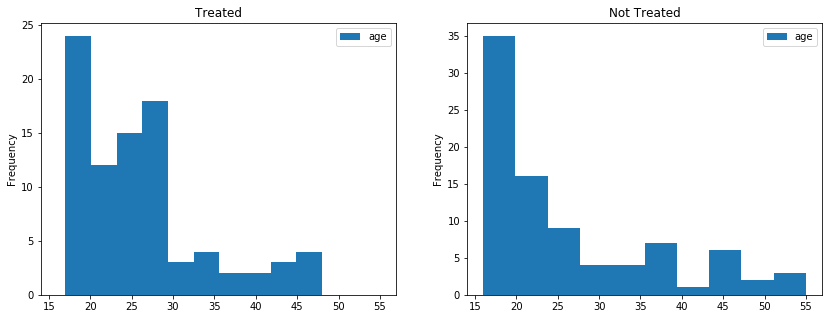

In [77]:
shared_plot_by('age', 'hist', patients_black_treated_matched, patients_black_not_treated)

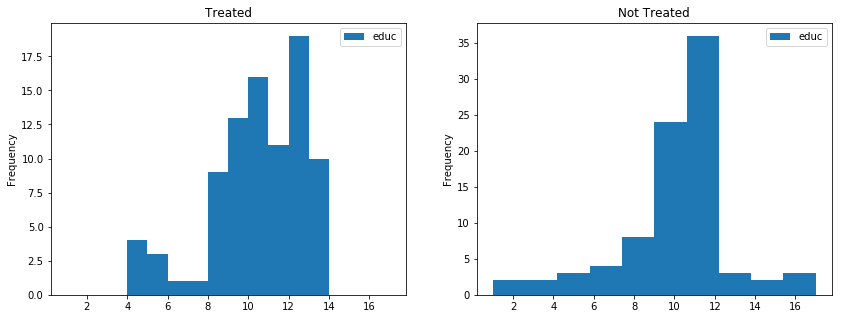

In [78]:
shared_plot_by('educ', 'hist', patients_black_treated_matched, patients_black_not_treated)

Secondly, we will look at the hispanic person

In [79]:
patients_hispan_treated['re78'].describe()

count       11.000000
mean      7122.515564
std       7320.482894
min        559.443200
25%       3191.927000
50%       5112.014000
75%       8440.646500
max      26817.600000
Name: re78, dtype: float64

In [80]:
patients_hispan_not_treated_matched = patients_hispan_not_treated.loc[np.array(matching_hispan)[:,1]]
patients_hispan_not_treated_matched['re78'].describe()

count       11.000000
mean      7333.688155
std       7106.273863
min          0.000000
25%       1136.371850
50%       5661.171000
75%      11820.333500
max      18891.260000
Name: re78, dtype: float64

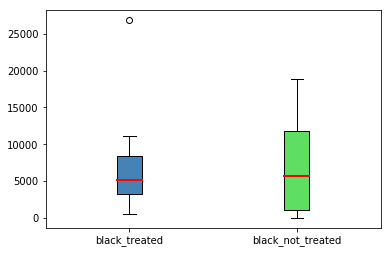

In [81]:
make_boxplot(patients_hispan_treated, patients_hispan_not_treated_matched, 're78', ['black_treated', 'black_not_treated'], ['steelblue', '#5EDF63'])

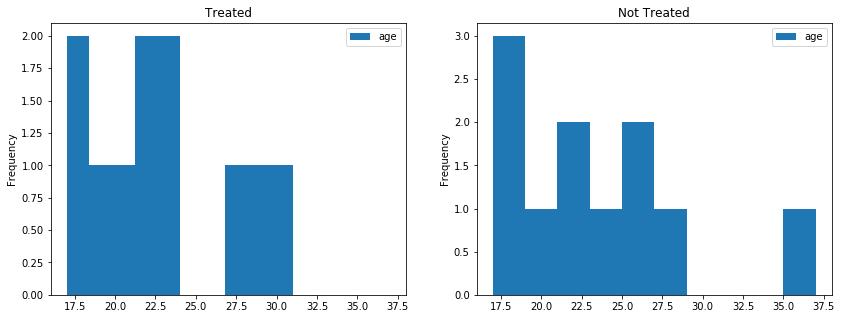

In [82]:
shared_plot_by('age', 'hist', patients_hispan_treated, patients_hispan_not_treated_matched)

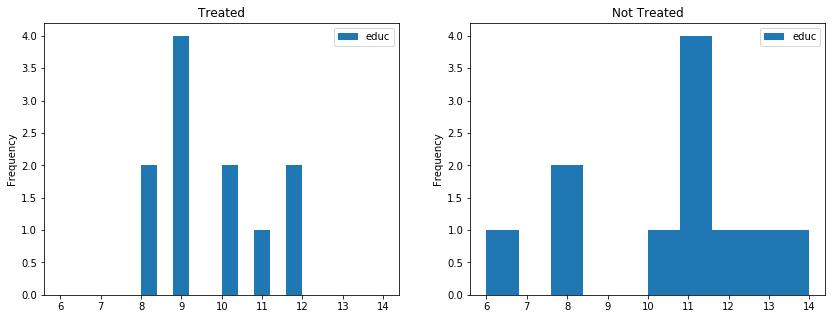

In [83]:
shared_plot_by('educ', 'hist', patients_hispan_treated, patients_hispan_not_treated_matched)

Finally, we will look at the person who are not black or hispanic

In [84]:
patients_noBlack_noHispan_treated['re78'].describe()

count       18.000000
mean      7720.992278
std       5564.944194
min          0.000000
25%       4254.658000
50%       5998.226500
75%      12582.537500
max      18783.350000
Name: re78, dtype: float64

In [85]:
patients_noBlack_noHispan_not_treated_matched = patients_noBlack_noHispan_not_treated.loc[np.array(matching_noBlack_noHispan)[:,1]]
patients_noBlack_noHispan_not_treated_matched['re78'].describe()

count       18.000000
mean      6454.791667
std       6844.735381
min          0.000000
25%        429.279500
50%       4534.404000
75%       8498.035750
max      23764.800000
Name: re78, dtype: float64

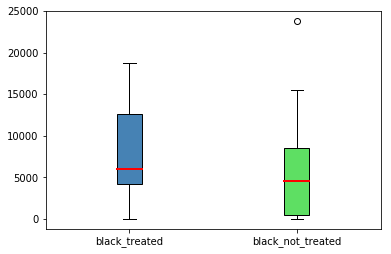

In [86]:
make_boxplot(patients_noBlack_noHispan_treated, patients_noBlack_noHispan_not_treated_matched, 're78', ['black_treated', 'black_not_treated'], ['steelblue', '#5EDF63'])

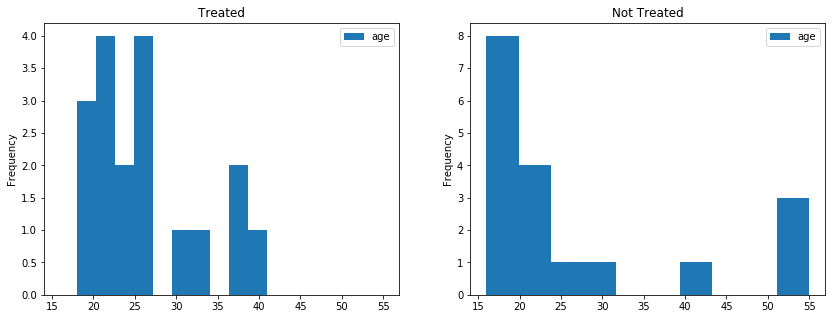

In [87]:
shared_plot_by('age', 'hist', patients_noBlack_noHispan_treated, patients_noBlack_noHispan_not_treated_matched)

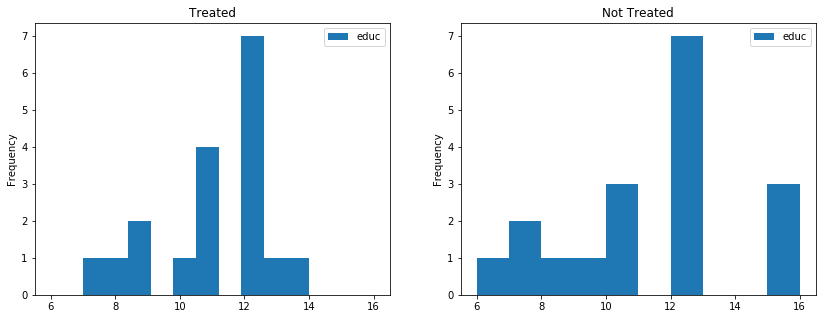

In [88]:
shared_plot_by('educ', 'hist', patients_noBlack_noHispan_treated, patients_noBlack_noHispan_not_treated_matched)

### 6. A less naive analysis

### Task 2.1

#### Description
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

#### Solution
We start by loading the dataset

In [89]:
from sklearn.datasets import fetch_20newsgroups
# Retrieve data
news_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [90]:
# See what an element looks like
news_data['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
vectors = vectorizer.fit_transform(news_data.data)

Now we can get the idf by calling vectorizer attribute idf_

In [92]:
vectors

<11314x101322 sparse matrix of type '<class 'numpy.float64'>'
	with 755809 stored elements in Compressed Sparse Row format>

We can also see the details by calling "vectorizer.vocabulary_" but there is a loss of values

In [93]:
news_data.target

array([7, 4, 4, ..., 3, 1, 8])

In [94]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english')
data_vec = vectorizer.fit_transform(news_data.data)

In [95]:
from sklearn.model_selection import train_test_split
# Split the data to have 80% train, 20% test and val
x_train, x_test_val, y_train, y_test_val = train_test_split(data_vec, news_data.target, test_size = 0.2)
# Split test and val to have 10% each
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size = 0.5)
np.shape(y_train) 

(9051,)

In [96]:
def mse(pred, target):
    e = pred - target
    return e@e

In [97]:
np.shape(x_test_val)

(2263, 101322)

In [98]:
np.shape(x_train)

(9051, 101322)

In [99]:
from sklearn.ensemble import RandomForestRegressor

n_estim, dep, min_error = 0, 0, 100000

for estim in range(1, 10):
    for depth in range(1, 8):
        regr = RandomForestRegressor(n_estimators=estim, max_depth=depth)
        X_train = regr.fit(x_train, y_train)
        pred = regr.predict(x_val)
        error = mse(pred, y_val)
        if(error < min_error):
            min_error = error
            n_estim = estim
            dep = depth

In [100]:
min_error

25216.000371856335

In [101]:
def ratio_prediction(pred, value):
    return np.in1d(pred, value).sum()/len(pred)

In [102]:
ratio_prediction([1,2,3], [0,2,3])

0.66666666666666663

In [103]:
# Use cross-validated best parameters to predict for test set
regr = RandomForestRegressor(n_estimators=n_estim, max_depth=dep)
X_train = regr.fit(x_train, y_train)
test_pred = np.round_(regr.predict(x_train))
ratio_prediction(test_pred, y_test)

1.0